In [94]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 

from scipy import stats
from scipy.stats.mstats import winsorize
from scipy.stats import shapiro
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.feature_selection import SelectKBest, chi2 , f_classif, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, cross_val_score, LeaveOneOut
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree
import joblib
import pickle
from pathlib import Path

### EDA, data engineering, ML models training 
- Download prices of financial assets (features: prices, targes
- EDA and preprocessing
- Feature engineering
- Model training for classification/regression taks (predicting the next day's direction or/and magnitude).

In [4]:
'''Download data for training ML models (predicting AAPL price for the next day) as pd.DataFrame using yfinance API'''

data = yf.download("SPY AAPL CHF=X ^TNX ^VIX EURUSD=X", start="2005-01-01", end="2023-04-30")

[*********************100%***********************]  6 of 6 completed


In [55]:
data.columns;

In [56]:
selected_col = [('Open',  'AAPL'),
                ('High',  'AAPL'),
                ('Low',  'AAPL'),
                ('Volume',  'AAPL'),
                ('Adj Close',  'AAPL'),
                ('Adj Close',   'SPY'),
                ('Adj Close',   '^VIX'),
                ('Adj Close',   '^TNX'),
                ('Adj Close',   'CHF=X'),
                ('Adj Close',   'EURUSD=X')
               ]

In [57]:
df = data[selected_col]

In [58]:
df.head()

Open      High       Low        Volume Adj Close             \
                AAPL      AAPL      AAPL          AAPL      AAPL        SPY   
Date                                                                          
2005-01-03  1.156786  1.162679  1.117857  6.919920e+08  0.960587  84.571579   
2005-01-04  1.139107  1.169107  1.124464  1.096810e+09  0.970453  83.538177   
2005-01-05  1.151071  1.165179  1.143750  6.804336e+08  0.978952  82.961693   
2005-01-06  1.154821  1.159107  1.130893  7.055552e+08  0.979711  83.383469   
2005-01-07  1.160714  1.243393  1.156250  2.227450e+09  1.051046  83.263969   

                                            
             ^VIX   ^TNX   CHF=X  EURUSD=X  
Date                                        
2005-01-03  14.08  4.220  1.1470  1.347001  
2005-01-04  13.98  4.283  1.1676  1.328198  
2005-01-05  14.09  4.277  1.1669  1.328004  
2005-01-06  13.58  4.272  1.1740  1.318305  
2005-01-07  13.49  4.285  1.1841  1.306097

In [59]:
# Drop MultiIndex
df.columns = df.columns.map(''.join)

In [60]:
# Resting Date Index
df.index = data.index

In [61]:
df.head()

,OpenAAPL,HighAAPL,LowAAPL,VolumeAAPL,Adj CloseAAPL,Adj CloseSPY,Adj Close^VIX,Adj Close^TNX,Adj CloseCHF=X,Adj CloseEURUSD=X
Date,,,,,,,,,,
2005-01-03,1.156786,1.162679,1.117857,6.919920e+08,0.960587,84.571579,14.08,4.220,1.1470,1.347001
2005-01-04,1.139107,1.169107,1.124464,1.096810e+09,0.970453,83.538177,13.98,4.283,1.1676,1.328198
2005-01-05,1.151071,1.165179,1.143750,6.804336e+08,0.978952,82.961693,14.09,4.277,1.1669,1.328004
2005-01-06,1.154821,1.159107,1.130893,7.055552e+08,0.979711,83.383469,13.58,4.272,1.1740,1.318305
2005-01-07,1.160714,1.243393,1.156250,2.227450e+09,1.051046,83.263969,13.49,4.285,1.1841,1.306097


### Exploratory data analysis

In [72]:
df.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4574 entries, 2005-01-04 to 2023-04-28
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   OpenAAPL           4574 non-null   float64
 1   HighAAPL           4574 non-null   float64
 2   LowAAPL            4574 non-null   float64
 3   VolumeAAPL         4574 non-null   float64
 4   Adj CloseAAPL      4574 non-null   float64
 5   Adj CloseSPY       4574 non-null   float64
 6   Adj Close^VIX      4574 non-null   float64
 7   Adj Close^TNX      4574 non-null   float64
 8   Adj CloseCHF=X     4574 non-null   float64
 9   Adj CloseEURUSD=X  4574 non-null   float64
dtypes: float64(10)
memory usage: 393.1 KB


In [71]:
# Check for Nans
df.isna().sum();

In [64]:
# Get rid of Nans
pd.set_option('mode.chained_assignment', None)
df.dropna(inplace=True)

In [73]:
df.isna().sum();

In [70]:
# Check for Null values
df.isnull().sum();

In [66]:
# from prices to returns
df = df.pct_change()
df = df.drop(df.index[0])

In [75]:
# Check for duplicates 
df.duplicated().value_counts()

False    4574
dtype: int64

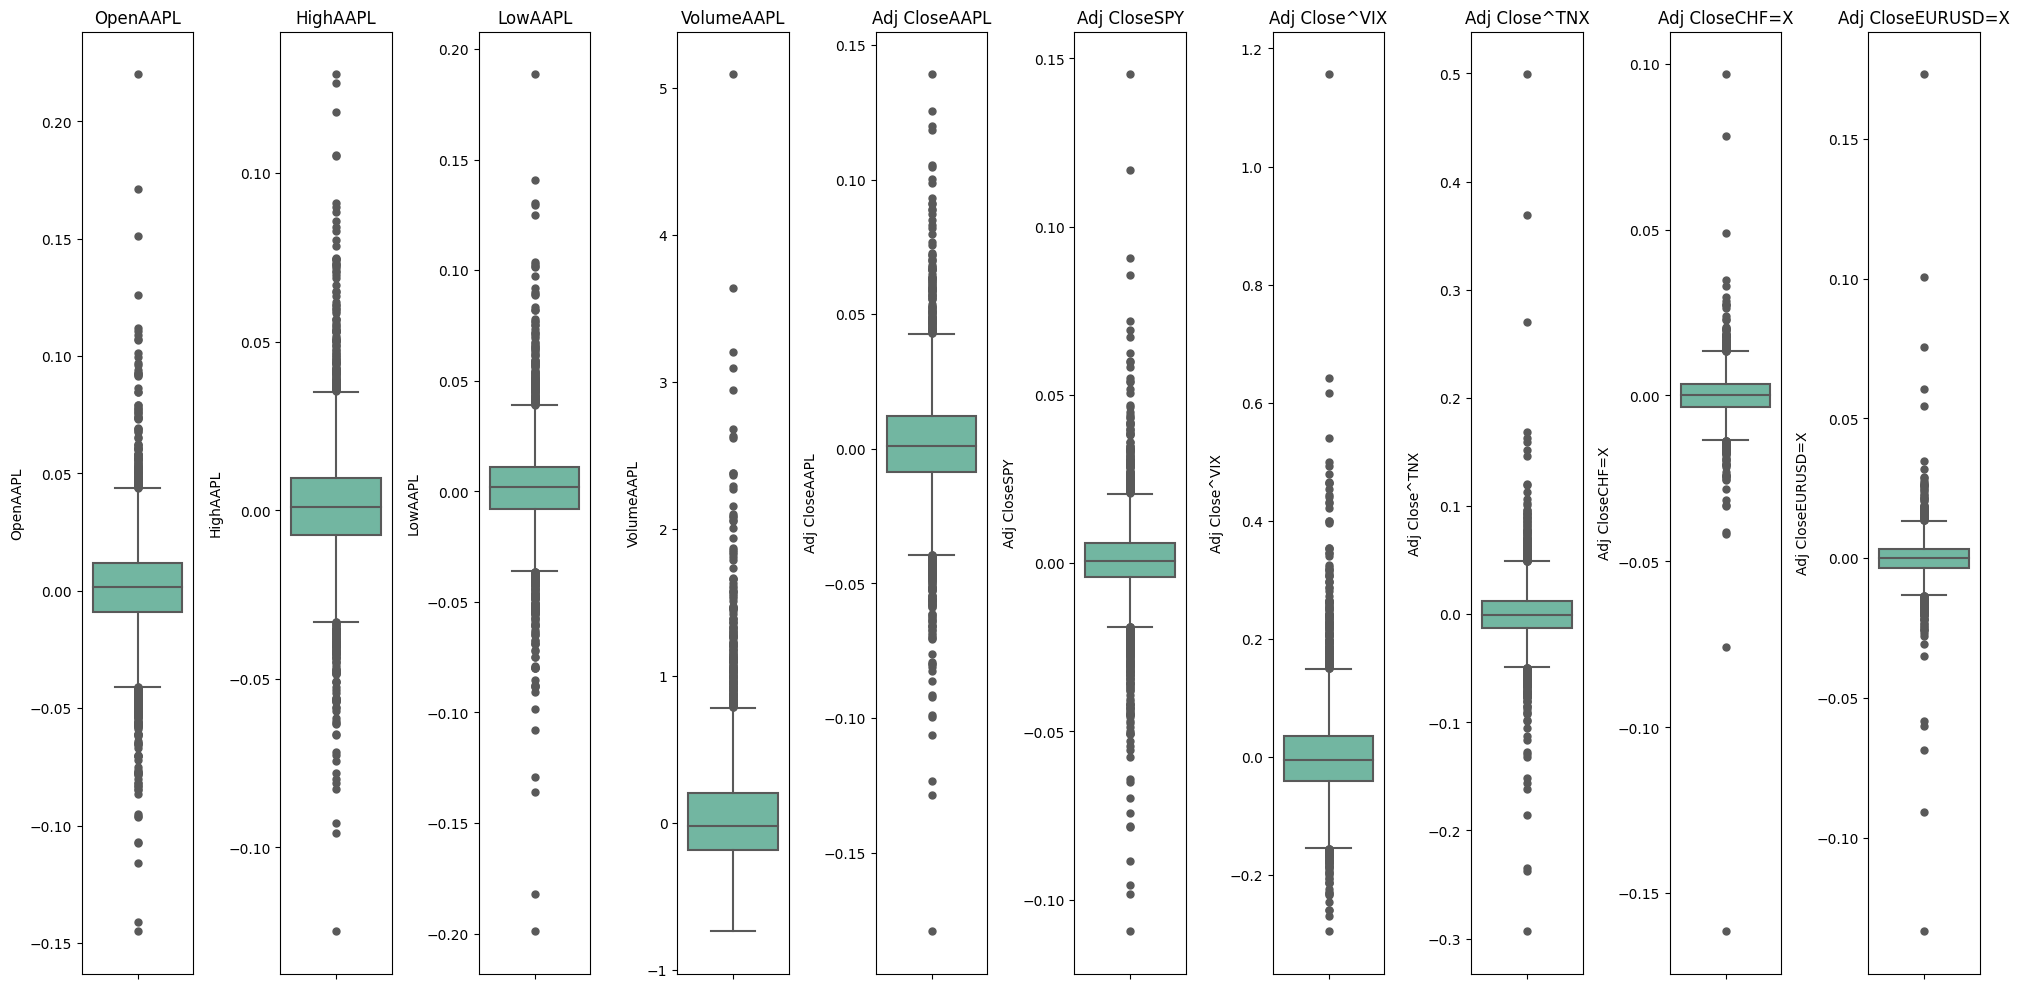

In [77]:
# Look for anomalies
fig, axes = plt.subplots(1, 10, figsize=(20, 10))


for name, ax in zip(df.columns, axes.flatten()):
    sns.boxplot(y=name,
                data=df,
                orient='v',
                ax=ax,
                flierprops={"marker": "o"},
                palette='Set2'
               ).set_title(name)
    
fig.tight_layout()

In [76]:
df.shape

(4574, 10)

# EDA

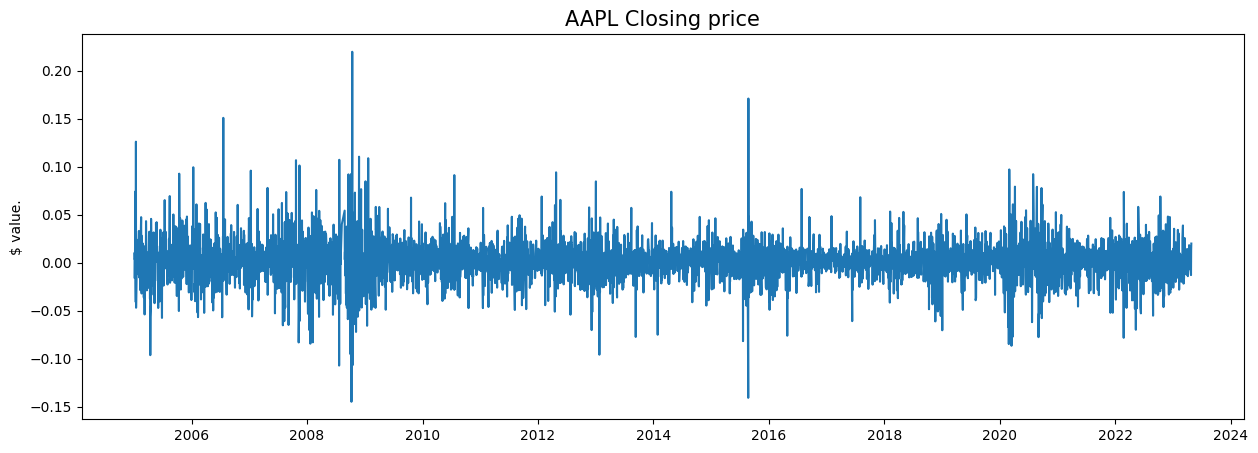

In [67]:
#Plot 
plt.figure(figsize=(15,5))
plt.plot(df['OpenAAPL'])
plt.title('AAPL Closing price', fontsize=15)
plt.ylabel('$ value.')
plt.show()

In [204]:
df.shape

(4573, 10)

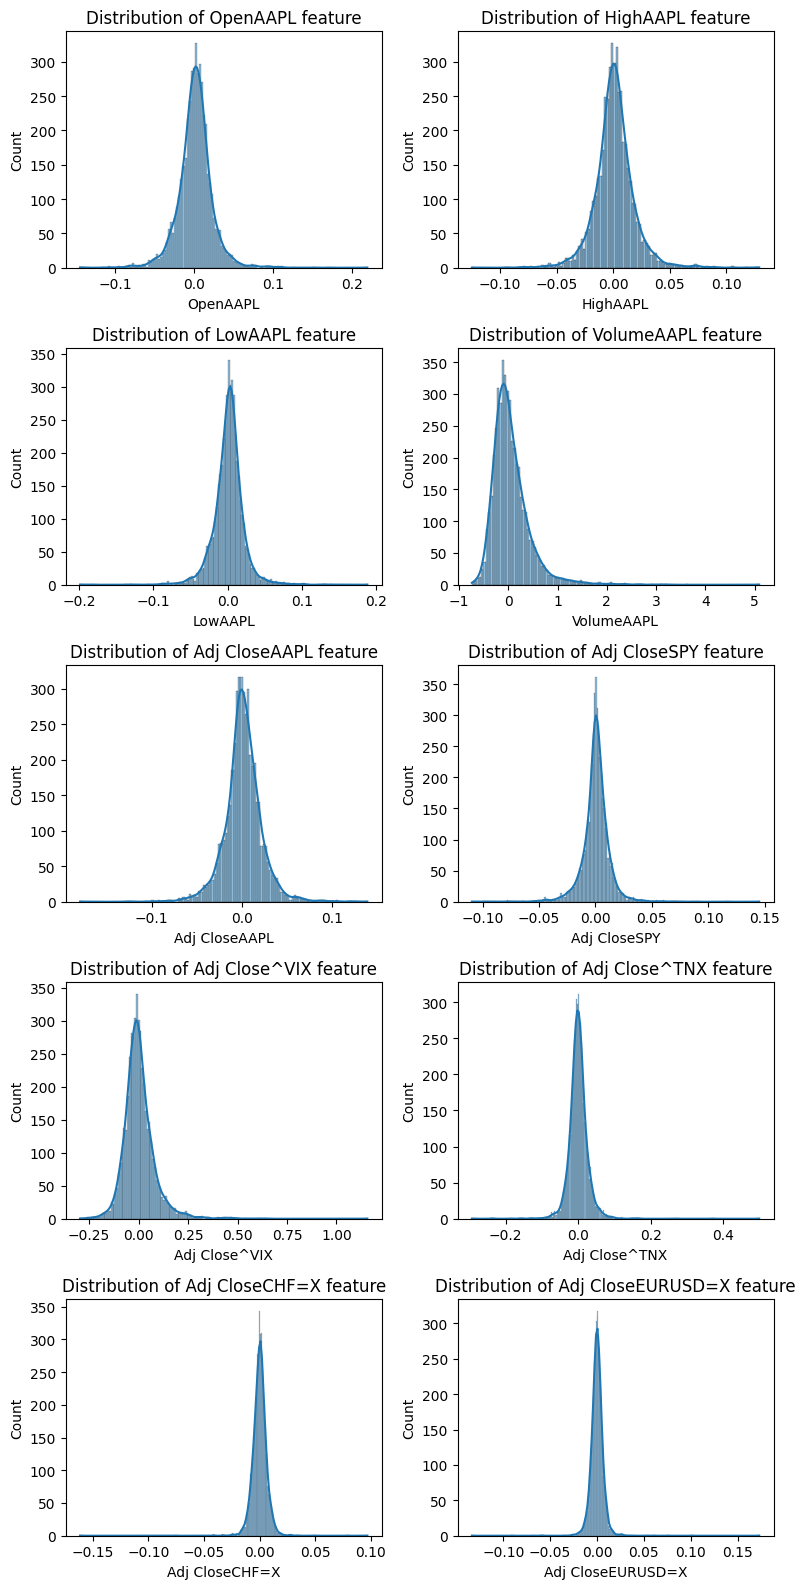

In [82]:
# Univariate distributions 

features = df.columns.to_list()

fig = plt.figure(figsize=(8,16))

for i in range(len(features)):
            plt.subplot(5,2,i+1)
            sns.histplot(df[features[i]],kde=True)
            plt.title(f"Distribution of {features[i]} feature")
            plt.tight_layout()
            plt.plot()

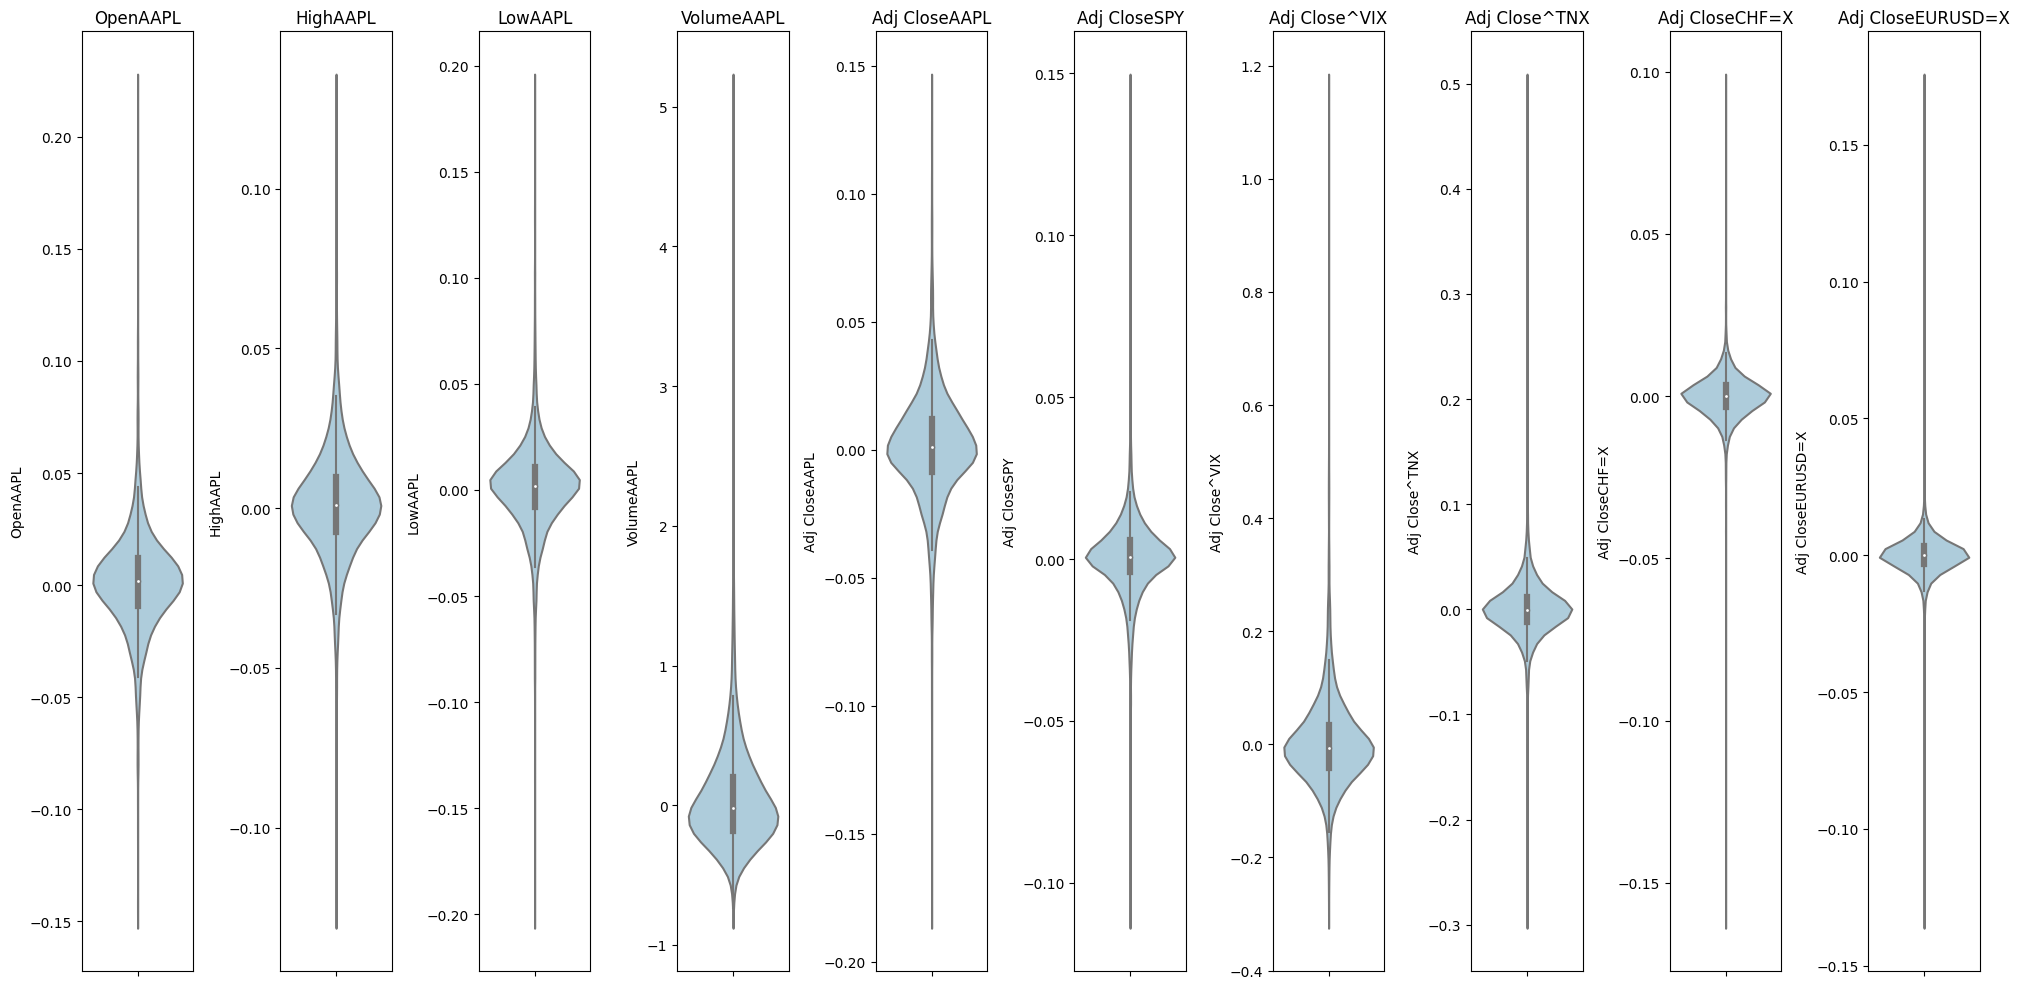

In [83]:
fig, axes = plt.subplots(1, 10, figsize=(20, 10))

for name, ax in zip(features, axes.flatten()):
    sns.violinplot(y=name, 
                   data=df,
                   orient='v',
                   ax=ax,
                   palette="Paired"
                  ).set_title(name)
    
fig.tight_layout()

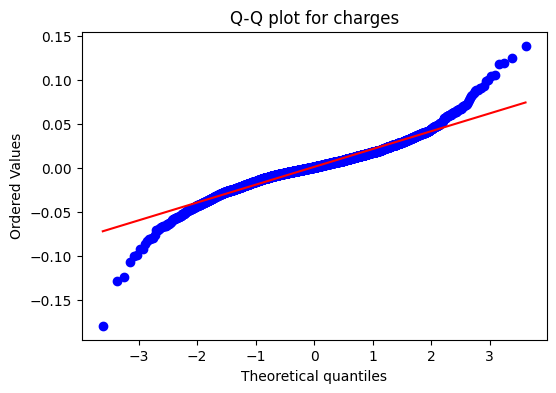

In [101]:
# Looking for the distribution plot
plt.figure(figsize=(6,4))
stats.probplot(df.iloc[:,4], plot= plt, dist="norm")
plt.title('Q-Q plot for charges')
plt.show()

### Exploring relationships among variables

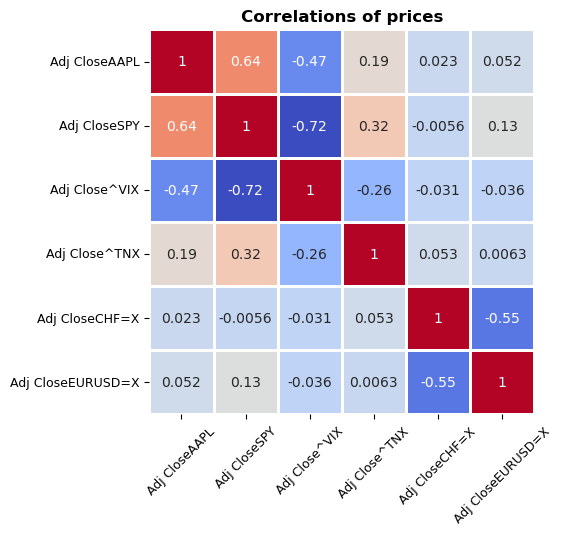

In [205]:
plt.figure(figsize=(5, 5))
heat = df.iloc[:,4:].corr()
sns.heatmap(heat, annot=True, square=True, cmap='coolwarm', linewidths=0.9, cbar=False)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.xticks(rotation=45)
plt.title('Correlations of prices', fontsize=12, weight='bold')
plt.show()

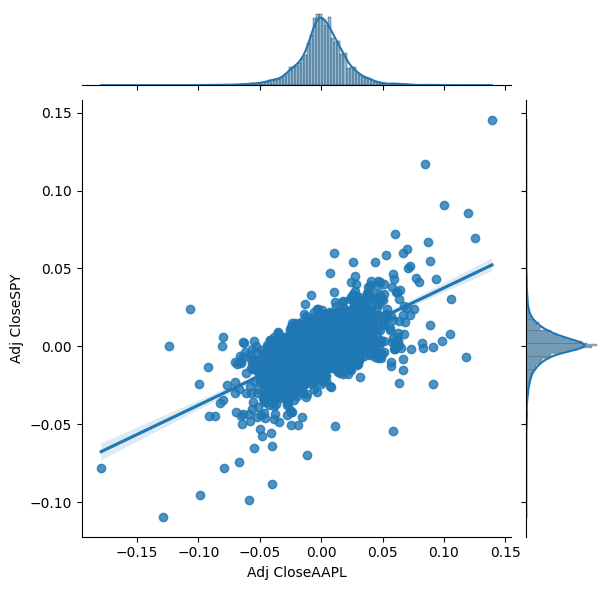

In [105]:
sns.jointplot(x='Adj CloseAAPL',
              y='Adj CloseSPY',
              data=df
              , kind="reg");

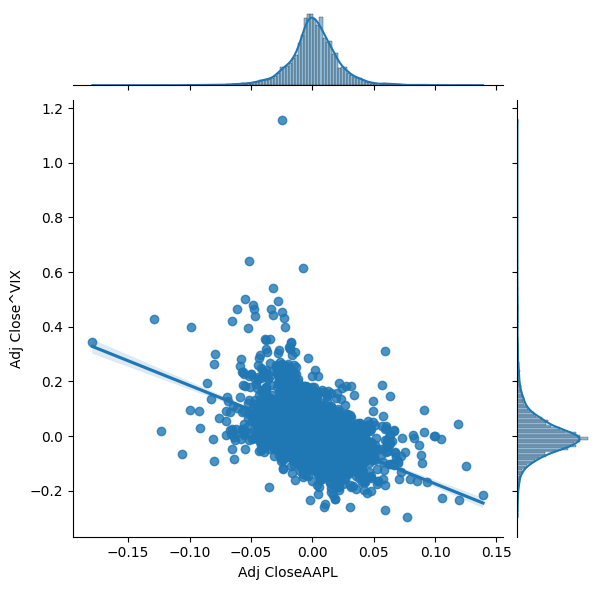

In [108]:
sns.jointplot(x='Adj CloseAAPL',
              y='Adj Close^VIX',
              data=df
              , kind="reg");

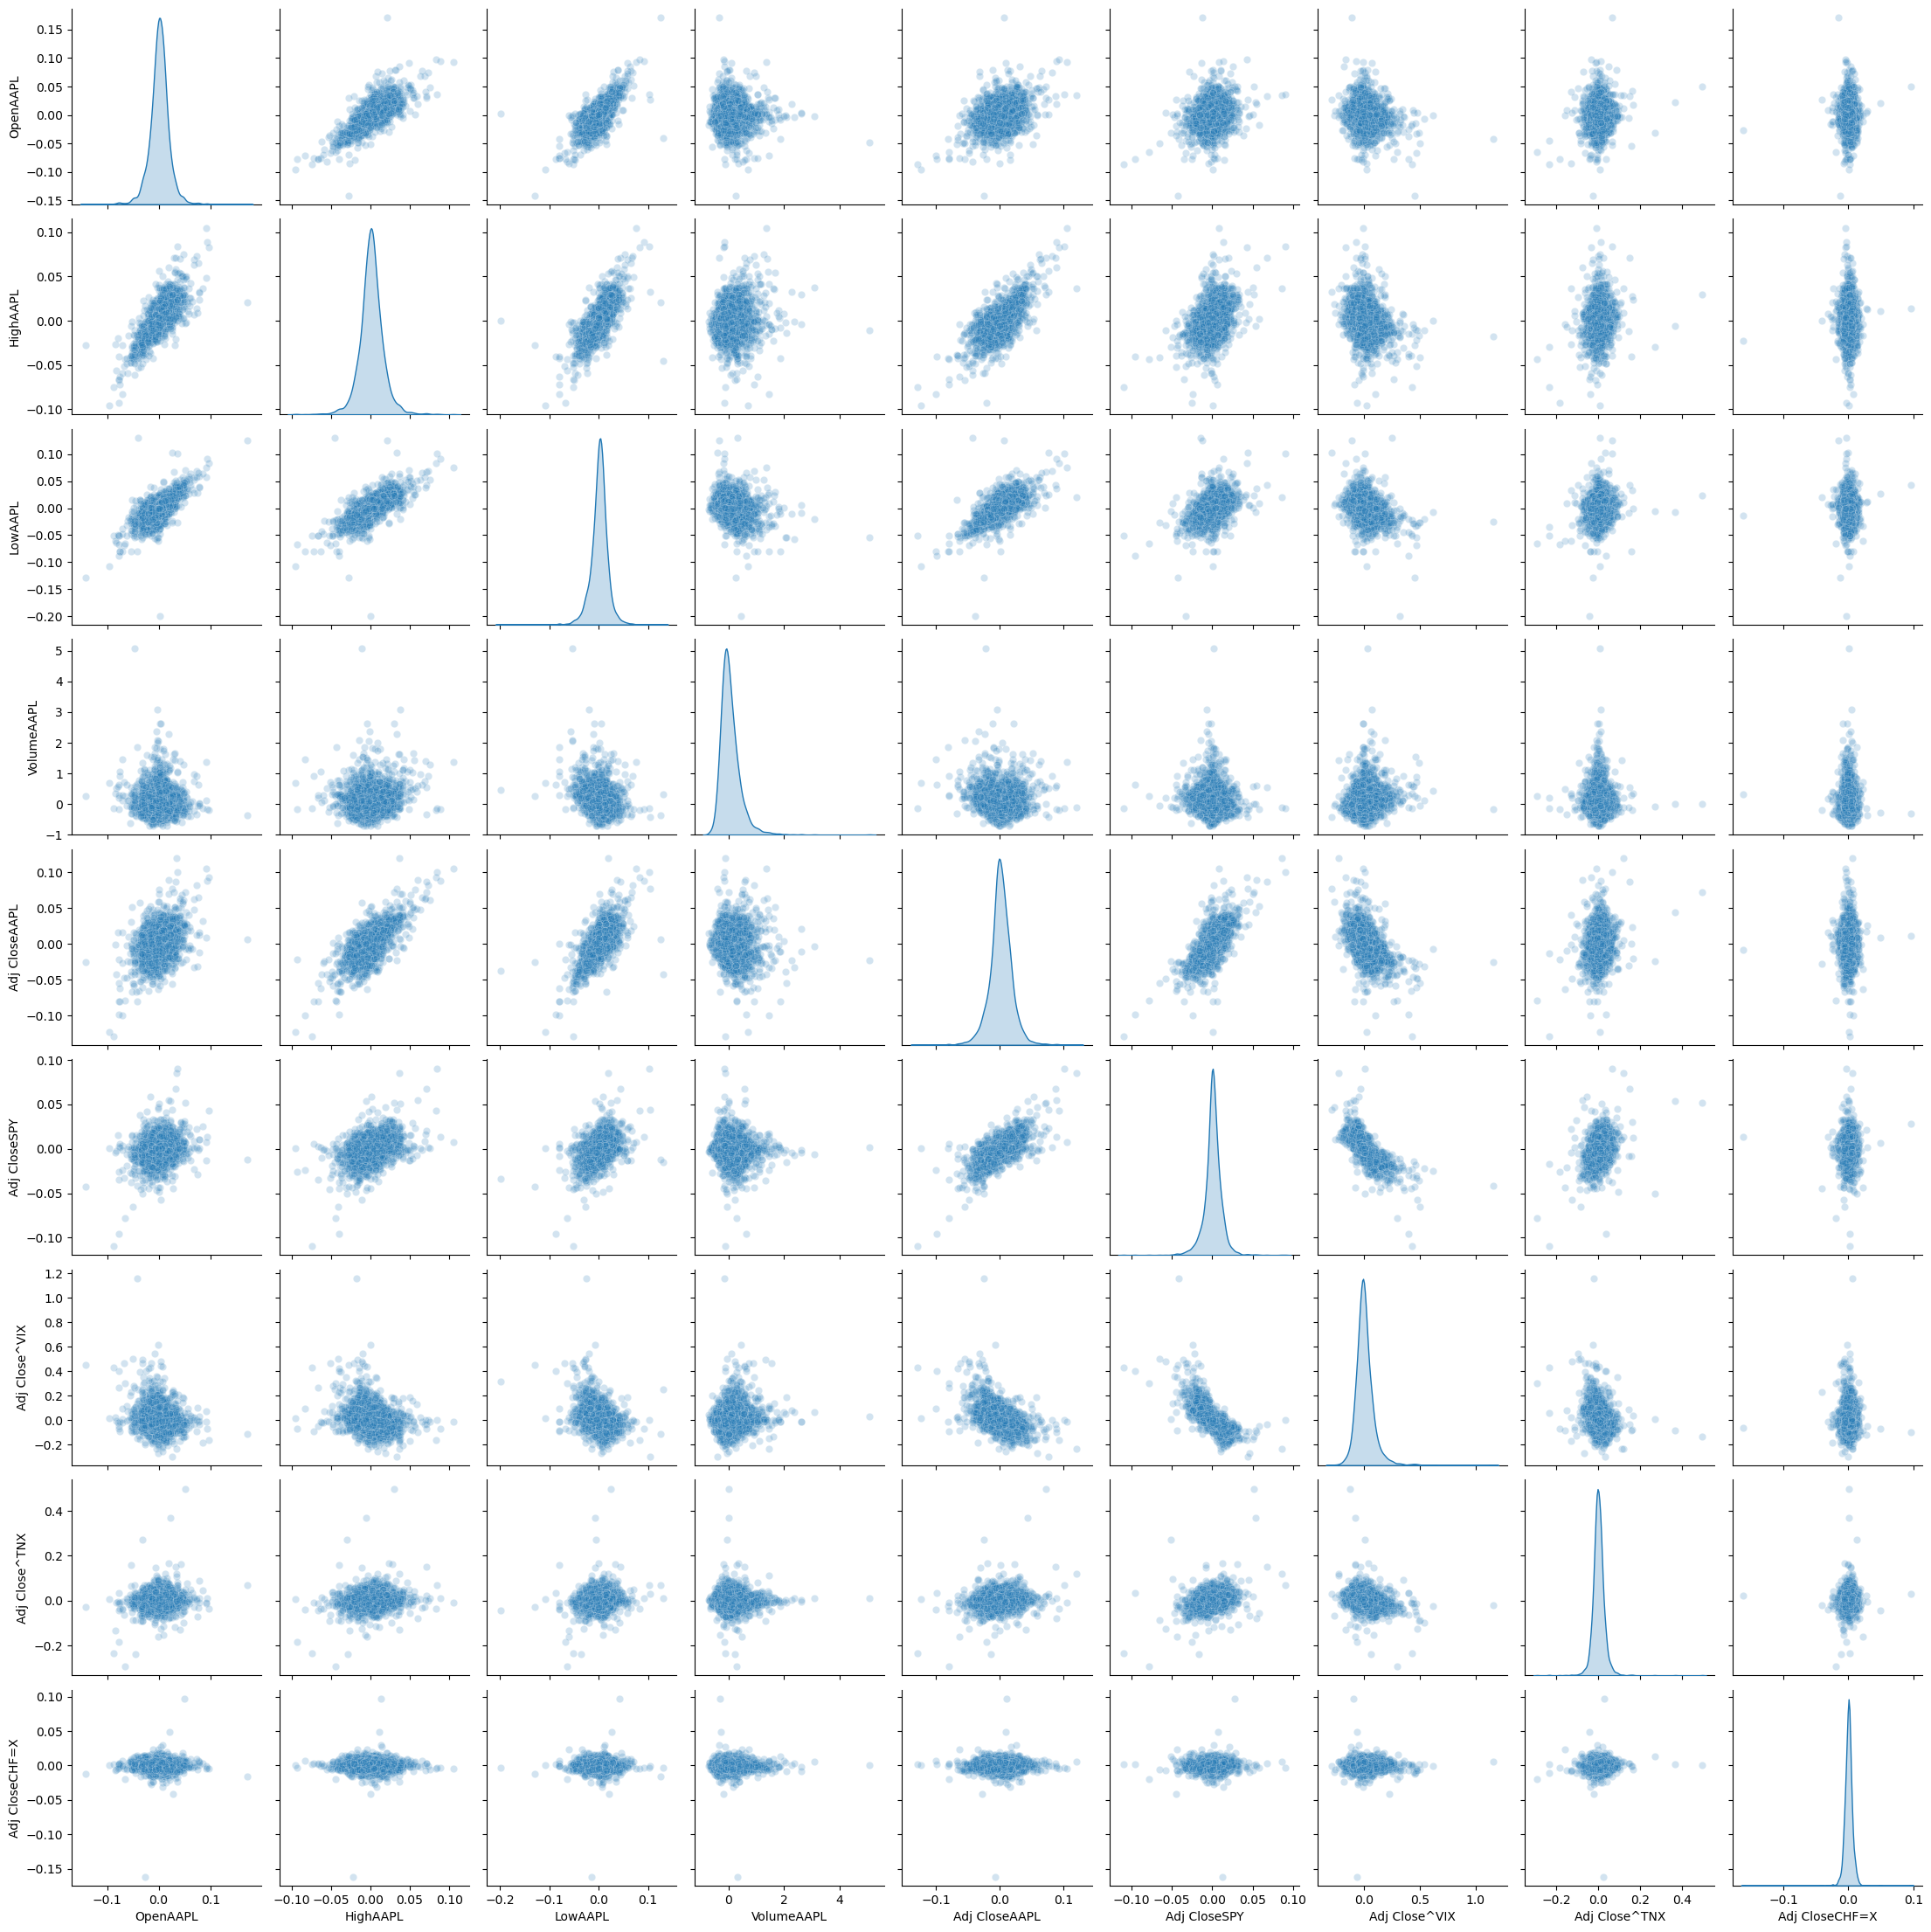

In [209]:
sns.pairplot(df_pct, diag_kind="kde", plot_kws={"alpha": 0.2});

### Adding the targer and new features for further exploration

### Feature Engineering


In [143]:
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Quarter'] = df.index.quarter

In [144]:
df

,OpenAAPL,HighAAPL,LowAAPL,VolumeAAPL,Adj CloseAAPL,Adj CloseSPY,Adj Close^VIX,Adj Close^TNX,Adj CloseCHF=X,Adj CloseEURUSD=X,...,Month,Year,Quarter,d2_mean,week_mean,month_mean,quarter_mean,ratio_open_close,ratio_high_close,ratio_low_close
Date,,,,,,,,,,,,,,,,,,,,,
2005-05-12,0.006250,-0.002243,0.026880,-0.524853,-0.041561,-0.011003,0.115571,-0.004284,0.009706,-0.010373,...,5,2005,2,0.767569,0.197140,0.147591,-0.029479,-0.150378,0.053981,-0.646768
2005-05-13,-0.034443,-0.010115,0.002059,-0.275734,0.018752,-0.001983,0.012407,-0.015057,0.007230,-0.005122,...,5,2005,2,-0.608182,-0.491850,-0.260508,0.070362,-1.836803,-0.539416,0.109796
2005-05-16,0.010526,0.013341,0.013501,-0.325052,0.022433,0.009333,-0.039216,0.000971,-0.003100,0.001896,...,5,2005,2,0.917952,-0.187713,-0.191695,0.065589,0.469226,0.594709,0.601842
2005-05-17,0.016782,-0.006722,0.000290,0.240461,-0.005345,0.006678,-0.070791,-0.001939,0.002782,-0.002924,...,5,2005,2,-1.598324,1.338642,0.959214,-0.262531,-3.139523,1.257585,-0.054161
2005-05-18,0.008821,0.059222,0.013029,0.082228,0.013575,0.010291,-0.064516,-0.011902,-0.006365,0.006188,...,5,2005,2,0.303119,-0.307951,-0.370162,0.054891,0.649816,4.362438,0.959737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,-0.000303,-0.005107,-0.003648,-0.280913,0.001879,0.001043,0.007156,-0.015406,-0.000695,0.001946,...,4,2023,2,-2.103303,-0.096476,1.941982,0.874721,-0.161272,-2.718363,-1.941749
2023-04-25,0.001152,0.004287,-0.000976,0.161253,-0.009436,-0.015874,0.110716,-0.033855,-0.005170,0.006116,...,4,2023,2,0.400455,0.130059,-0.306431,-0.155051,-0.122040,-0.454380,0.103468
2023-04-26,-0.012894,-0.006193,-0.005680,-0.066003,-0.000061,-0.004236,0.004264,0.010601,0.005332,-0.007334,...,4,2023,2,77.699744,20.506720,-39.594658,-26.753255,210.993723,101.342368,92.944560


In [145]:
d2_mean = df.rolling(2).mean()["Adj CloseAAPL"]
week_mean = df.rolling(7).mean()["Adj CloseAAPL"]
month_mean = df.rolling(30).mean()["Adj CloseAAPL"]
quarter_mean = df.rolling(90).mean()["Adj CloseAAPL"]

In [146]:
# Adding new features : rolling means and ratios 
df["d2_mean"] = d2_mean / df["Adj CloseAAPL"]
df["week_mean"] = week_mean / df["Adj CloseAAPL"]
df["month_mean"] = month_mean / df["Adj CloseAAPL"]
df["quarter_mean"] = quarter_mean / df["Adj CloseAAPL"]

df["ratio_open_close"] = df["OpenAAPL"] / df["Adj CloseAAPL"]
df["ratio_high_close"] = df["HighAAPL"] / df["Adj CloseAAPL"]
df["ratio_low_close"] = df["LowAAPL"] / df["Adj CloseAAPL"]

In [147]:
df.head(3)

,OpenAAPL,HighAAPL,LowAAPL,VolumeAAPL,Adj CloseAAPL,Adj CloseSPY,Adj Close^VIX,Adj Close^TNX,Adj CloseCHF=X,Adj CloseEURUSD=X,...,Month,Year,Quarter,d2_mean,week_mean,month_mean,quarter_mean,ratio_open_close,ratio_high_close,ratio_low_close
Date,,,,,,,,,,,,,,,,,,,,,
2005-05-12,0.006250,-0.002243,0.026880,-0.524853,-0.041561,-0.011003,0.115571,-0.004284,0.009706,-0.010373,...,5,2005,2,NaN,NaN,NaN,NaN,-0.150378,0.053981,-0.646768
2005-05-13,-0.034443,-0.010115,0.002059,-0.275734,0.018752,-0.001983,0.012407,-0.015057,0.007230,-0.005122,...,5,2005,2,-0.608182,NaN,NaN,NaN,-1.836803,-0.539416,0.109796
2005-05-16,0.010526,0.013341,0.013501,-0.325052,0.022433,0.009333,-0.039216,0.000971,-0.003100,0.001896,...,5,2005,2,0.917952,NaN,NaN,NaN,0.469226,0.594709,0.601842


In [148]:
df.dropna(inplace=True)

### Defining target

Let's start preparing the data for our prediction task - forecasting whether the price will increase or decrease tomorrow based on today's data. 

(1) determine the target variable to predict (whether the price will go up or down tomorrow). We will assign a value of 1 to the target if the price increases and 0 if it decreases.

To ensure that we are not using data from the same day to make predictions, we will shift the data from previous days "forward" by one day. This will enable us to use the data to predict the target price without including data from the same day.

In [173]:
# Setting target
new_data = df[["Adj CloseAAPL"]]
new_data = new_data.rename(columns = {'Adj CloseAAPL':'Actual_Close'})

In [174]:
# Define the target variable, to  determine whether there was an increase or decrease in price.
new_data["Target"] = df.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj CloseAAPL"]

In [175]:
# Shift forward 
data_prev = df.copy()
data_prev = data_prev.shift(1)

In [176]:
data_prev.head(3)

,OpenAAPL,HighAAPL,LowAAPL,VolumeAAPL,Adj CloseAAPL,Adj CloseSPY,Adj Close^VIX,Adj Close^TNX,Adj CloseCHF=X,Adj CloseEURUSD=X,...,Month,Year,Quarter,d2_mean,week_mean,month_mean,quarter_mean,ratio_open_close,ratio_high_close,ratio_low_close
Date,,,,,,,,,,,,,,,,,,,,,
2005-09-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-09-20,0.016325,0.032806,0.022022,0.326100,0.027924,-0.003320,0.081996,-0.003519,0.007247,-0.008170,...,9.0,2005.0,3.0,0.981136,0.293811,0.249747,0.164160,0.584605,1.174833,0.788626
2005-09-22,0.038002,0.017394,0.036631,0.046059,0.010448,-0.008449,0.041186,-0.000942,0.002424,-0.001648,...,9.0,2005.0,3.0,1.836288,0.507855,0.726032,0.494038,3.637131,1.664802,3.505892


In [177]:
#Our next step involves merging the target variable with the columns that we have chosen to predict the target

In [178]:
#left_index=True, right_index=True
predictors = ['Adj CloseAAPL', 
              'VolumeAAPL', 
              'OpenAAPL',
              'HighAAPL', 
              'LowAAPL',
              'Day',
              'Weekday',
              'Quarter',
              'Adj Close^VIX',
              'Adj Close^TNX',
              'Adj CloseSPY',
              'd2_mean',
              'week_mean',
              'month_mean',
              'quarter_mean',
              'ratio_open_close',
              'ratio_high_close',
              'ratio_low_close'
             ]
#new_data = new_data.merge(data_prev[predictors],left_index=False, right_index=False)
new_data= new_data.join(data_prev[predictors]).iloc[1:]

In [179]:
new_data.head()

,Actual_Close,Target,Adj CloseAAPL,VolumeAAPL,OpenAAPL,HighAAPL,LowAAPL,Day,Weekday,Quarter,Adj Close^VIX,Adj Close^TNX,Adj CloseSPY,d2_mean,week_mean,month_mean,quarter_mean,ratio_open_close,ratio_high_close,ratio_low_close
Date,,,,,,,,,,,,,,,,,,,,
2005-09-20,0.010448,0.0,0.027924,0.326100,0.016325,0.032806,0.022022,19.0,0.0,3.0,0.081996,-0.003519,-0.003320,0.981136,0.293811,0.249747,0.164160,0.584605,1.174833,0.788626
2005-09-22,-0.024253,0.0,0.010448,0.046059,0.038002,0.017394,0.036631,20.0,1.0,3.0,0.041186,-0.000942,-0.008449,1.836288,0.507855,0.726032,0.494038,3.637131,1.664802,3.505892
2005-09-23,0.025048,1.0,-0.024253,-0.434360,-0.020947,-0.024902,-0.030234,22.0,3.0,3.0,0.054589,-0.015791,-0.005817,0.284594,-0.065603,-0.241745,-0.193135,0.863714,1.026782,1.246636
2005-09-26,0.012030,0.0,0.025048,0.204279,0.004240,0.019630,0.010133,23.0,4.0,3.0,-0.027757,0.017241,0.000824,0.015882,0.270730,0.280762,0.188161,0.169291,0.783678,0.404529
2005-09-27,-0.007430,0.0,0.012030,-0.021299,0.037044,0.019813,0.028549,26.0,0.0,3.0,0.006173,0.010829,0.001153,1.541104,0.989317,0.578336,0.407838,3.079407,1.647002,2.373231


In [180]:
new_data.dropna(inplace=True)

In [181]:
new_data = new_data[~new_data.isin([np.nan, np.inf, -np.inf]).any(1)]

###  Training baseline ML model
We can use timeseriessplit with cross validation or just hold some observations for test

In [229]:
X = new_data[predictors]
y = new_data['Target']

X_train, X_hold, y_train, y_hold= train_test_split(X , y, train_size=0.8)

In [233]:
time_split = TimeSeriesSplit(n_splits=15)
logit = LogisticRegression(C=1, random_state=77, solver='liblinear')


In [234]:
cv_scores = cross_val_score(logit, X, y, cv=time_split, 
                            scoring='f1', n_jobs=1) # hangs with n_jobs > 1, and locally this runs much faster


In [235]:
cv_scores, cv_scores.mean()

(array([0.48739496, 0.65587045, 0.58295964, 0.56872038, 0.57777778,
        0.62857143, 0.57142857, 0.57261411, 0.61410788, 0.67241379,
        0.64      , 0.64377682, 0.68049793, 0.61924686, 0.692607  ]),
 0.6138658400982394)

In [236]:
# Initialize a random forest classifier.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=77)

In [237]:
# Trand and test samples 

train = new_data.iloc[:-100]
test = new_data.iloc[-100:]
model.fit(train[predictors], train["Target"]);

In [238]:
predictions = model.predict(test[predictors])
predictions = pd.Series(predictions, index=test.index)
precision_score(test["Target"], predictions)

0.7872340425531915

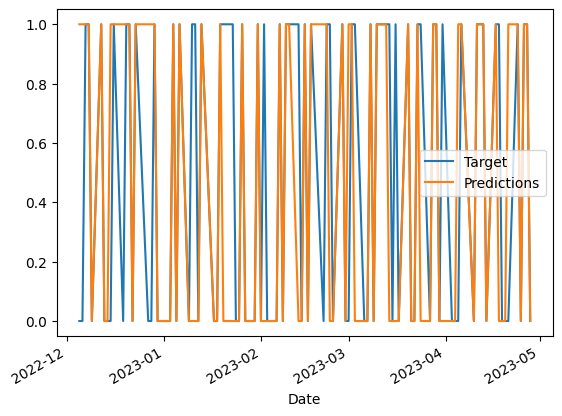

In [239]:
combined = pd.concat({"Target": test["Target"],"Predictions": predictions}, axis=1)
combined.plot();

In [240]:
#Feature importance 
model.feature_importances_

array([0.39859659, 0.00945733, 0.02159223, 0.12076755, 0.09523164,
       0.00336171, 0.00588305, 0.00052537, 0.01999558, 0.01455902,
       0.07055526, 0.02441172, 0.02052487, 0.02850065, 0.05669161,
       0.04500449, 0.02344753, 0.04089381])

<BarContainer object of 18 artists>

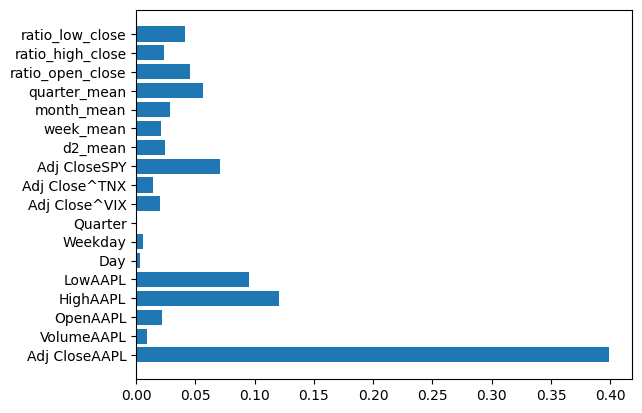

In [241]:
#Visualise feature importance
plt.barh(predictors, model.feature_importances_)


In [39]:
# Backtester

In [243]:
features = new_data[predictors]
target = new_data['Target']
 
scaler = StandardScaler()
features = scaler.fit_transform(features)
 
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=77)

print(X_train.shape, X_valid.shape)

(3948, 18) (439, 18)


In [244]:
models = [RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=77), 
          LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]
 
for m in range(4):
  models[m].fit(X_train, Y_train)
 
  print(f'{models[m]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[m].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, models[m].predict_proba(X_valid)[:,1]))
  print();

RandomForestClassifier(min_samples_split=200, random_state=77) : 
Training Accuracy :  0.8525194190309973
Validation Accuracy :  0.7970734744707348

LogisticRegression() : 
Training Accuracy :  0.8212444571650848
Validation Accuracy :  0.7937318389373182

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.8328114759131563
Validation Accuracy :  0.7817247820672479

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraint

In [245]:
Xnew = train.iloc[:,2:]

In [246]:
train.shape

(4287, 20)

In [247]:
ynew = model.predict(Xnew)

In [248]:
ynew

array([0., 0., 1., ..., 1., 0., 0.])

In [249]:
#adding predictions to the dataset

In [250]:
predictions = model.predict(new_data.iloc[:,2:])
predictions 

array([0., 0., 1., ..., 1., 1., 0.])

In [251]:
#predictions = pd.DataFrame(predictions, dtype='str')
predictions = pd.DataFrame(predictions)

In [252]:
#predictions.reset_index(drop=True, inplace=True)

In [253]:
predictions

,0
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0
...,...
4382,1.0
4383,0.0
4384,1.0
4385,1.0


In [254]:
new_data["Date_id"] = new_data.index

In [255]:
new_data.reset_index(drop=True, inplace=True )

In [256]:
#data_and_predictions['Prediction'] = predictions.reset_index()[0]

In [257]:
new_data['Prediction'] = predictions
new_data['Ticker'] = 'AAPL'

In [258]:
new_data.index = new_data['Date_id']

In [259]:
del new_data['Date_id']

In [260]:
db_predictions_aapl = new_data[['Prediction','Ticker']]

In [261]:
db_predictions_aapl

,Prediction,Ticker
Date_id,,
2005-09-20,0.0,AAPL
2005-09-22,0.0,AAPL
2005-09-23,1.0,AAPL
2005-09-26,0.0,AAPL
2005-09-27,0.0,AAPL
...,...,...
2023-04-24,1.0,AAPL
2023-04-25,0.0,AAPL
2023-04-26,1.0,AAPL


In [60]:
#Check that we can upload other tickers to the same table with the same dates

In [262]:
''' Adding backtester to estimate the performance of the model on the whole dataset'''

' Adding backtester to estimate the performance of the model on the whole dataset'

In [263]:
def backtest(data, model, predictors, start=1000, step=750):
    
    predictions = []
    
    # Incrementally loop over the whole dataset
    
    for i in range(start, new_data.shape[0], step):
        
        # Train test split
        train = new_data.iloc[0:i].copy()
        test = new_data.iloc[i:(i+step)].copy()

        # Fitting the model
        model.fit(train[predictors], train["Target"])

        # Makeing predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine test values and predictions
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

In [264]:
predictions = backtest(new_data, model, predictors)

In [265]:
predictions["Predictions"].value_counts()

0.0    2263
1.0    1124
Name: Predictions, dtype: int64

In [274]:
predictions

,Target,Predictions
Date_id,,
2009-10-21,0.0,0.0
2009-10-22,0.0,0.0
2009-10-23,0.0,0.0
2009-10-26,0.0,1.0
2009-10-27,0.0,1.0
...,...,...
2023-04-24,1.0,1.0
2023-04-25,0.0,0.0
2023-04-26,1.0,1.0


In [276]:
predictions["Target"].value_counts()

0.0    1736
1.0    1651
Name: Target, dtype: int64

In [267]:
precision_score(predictions["Target"], predictions["Predictions"])

0.7873665480427047

In [268]:
def classificator(model, X_train, y_train, X_test,y_test):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cv = RepeatedStratifiedKFold(n_splits = 2, # Repeats Stratified K-Fold n times with different randomization 
                                 n_repeats = 2,
                                 random_state = 77)
    print("CV Score : ",'{0:.2%}'.format(cross_val_score(model,
                                                         X_train,y_train,
                                                         cv = cv,
                                                         scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test, y_pred)))
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title('ROC_AUC Graph')
    plt.show()

def classificator_evaluation(model, X_test, y_test):
    
    cm = confusion_matrix(y_test, model.predict(X_test)) # Confuction martix
    labels = ['True Negative','False Positive','False Negative','True Positive']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    names = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(labels, counts, percentages)]
    names = np.asarray(names).reshape(2,2)
    sns.heatmap(cm,
                annot = names,
                cmap ='crest',
                fmt ='')
    
    # Classification Report
    print(classification_report(y_test, model.predict(X_test)))

CV Score :  80.35%
ROC_AUC Score :  78.00%


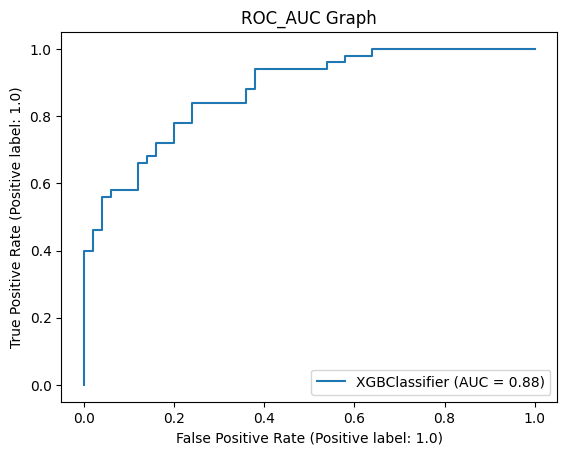

              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78        50
         1.0       0.78      0.78      0.78        50

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100



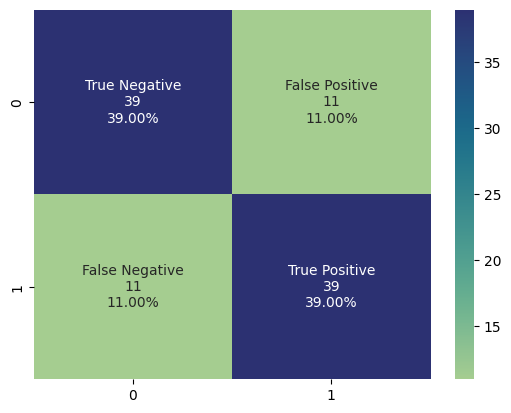

In [273]:
clf_xgb = XGBClassifier(learning_rate= 0.01, max_depth =3, n_estimators = 1000)
classificator(clf_xgb, X.iloc[:-100], y.iloc[:-100], X.iloc[-100:], y.iloc[-100:])
classificator_evaluation(clf_xgb, X.iloc[-100:], y.iloc[-100:])

### Saving (serializing) and loading models

In [ ]:
#Serializing our model using pickle

filename = datetime.datetime.now().strftime("%Y%m%d")

my_path = Path('serializedmodels/'+ filename)
with open(my_path, 'wb') as fp:
    pickle.dump(model, fp)

# my_path = Path('api/app/serializedmodels/'+ filename)
# with my_path.open('wb') as fp:
#     pickle.dump(model, fp)